In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the dataset
file_path = r"E:\TSA pro\Insitu_cleaned.csv"
data = pd.read_csv(file_path)

# Convert dataset into long format
data_long = data.melt(id_vars=['Lat', 'Lon'], var_name='Date', value_name='Groundwater_Level')

# Convert 'Date' column to datetime format
data_long['Date'] = pd.to_datetime(data_long['Date'], format='%Y-%m', errors='coerce')

# Convert 'Groundwater_Level' to numeric, force errors to NaN
data_long['Groundwater_Level'] = pd.to_numeric(data_long['Groundwater_Level'], errors='coerce')

# Fill missing values using linear interpolation
data_long['Groundwater_Level'] = data_long.groupby(['Lat', 'Lon'])['Groundwater_Level'].transform(lambda x: x.interpolate(method='linear'))

# Drop remaining missing values
data_long = data_long.dropna(subset=['Groundwater_Level'])

# Group data by (Lat, Lon)
location_groups = data_long.groupby(['Lat', 'Lon'])

# Dictionary to store forecasts
location_forecasts = {}

# Function to forecast using cubic spline
def forecast_spline(group, lat, lon):
    group = group.sort_values(by='Date')
    group['Days'] = (group['Date'] - group['Date'].min()).dt.days
    
    if len(group) < 4:
        return None  # Skip locations with insufficient data

    # Fit cubic spline
    x = group['Days'].values
    y = group['Groundwater_Level'].values
    spline = CubicSpline(x, y, bc_type='natural')
    
    # Forecast next 6 months (shorter period for accuracy)
    future_days = np.arange(x[-1], x[-1] + 180, 30)
    future_predictions = spline(future_days)
    future_dates = pd.date_range(start=group['Date'].max(), periods=len(future_predictions), freq='M')
    
    # Store results
    return pd.DataFrame({'Lat': lat, 'Lon': lon, 'Date': future_dates, 'Spline_Prediction': future_predictions})

# Function to forecast using SARIMA
def forecast_sarima(group, lat, lon):
    group = group.sort_values(by='Date')
    
    if len(group) < 12:
        return None  # SARIMA needs enough data
    
    # Fit SARIMA model
    sarima_model = SARIMAX(group['Groundwater_Level'], order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_results = sarima_model.fit(disp=False)
    
    # Forecast next 6 months
    sarima_forecast = sarima_results.forecast(steps=6)
    future_dates = pd.date_range(start=group['Date'].max(), periods=6, freq='M')
    
    return pd.DataFrame({'Lat': lat, 'Lon': lon, 'Date': future_dates, 'SARIMA_Prediction': sarima_forecast.values})

# Iterate over each location
for (lat, lon), group in location_groups:
    spline_forecast = forecast_spline(group, lat, lon)
    sarima_forecast = forecast_sarima(group, lat, lon)
    
    # Merge results if both models generate predictions
    if spline_forecast is not None and sarima_forecast is not None:
        forecast_df = pd.merge(spline_forecast, sarima_forecast, on=['Lat', 'Lon', 'Date'], how='outer')
        location_forecasts[(lat, lon)] = forecast_df

# Combine all forecasts
final_forecast_df = pd.concat(location_forecasts.values(), ignore_index=True)

# Save the results
forecast_file = r"E:\TSA pro\Spline_SARIMA_Forecast_upd.csv"
final_forecast_df.to_csv(forecast_file, index=False)

print(f"Forecasting completed using Spline & SARIMA. Results saved to {forecast_file}")

C:\Users\sridh\AppData\Local\Temp\ipykernel_11432\312526566.py:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=group['Date'].max(), periods=len(future_predictions), freq='M')
c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarim

Forecasting completed using Spline & SARIMA. Results saved to E:\TSA pro\Spline_SARIMA_Forecast_upd.csv


c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sridh\AppData\Local\Temp\ipykernel_11432\312526566.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=group['Date'].max(), periods=6, freq='M')


In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the dataset
file_path = r"E:\TSA pro\Insitu_cleaned.csv"
data = pd.read_csv(file_path)

# Convert dataset into long format
data_long = data.melt(id_vars=['Lat', 'Lon'], var_name='Date', value_name='Groundwater_Level')

# Convert 'Date' column to datetime format
data_long['Date'] = pd.to_datetime(data_long['Date'], format='%Y-%m', errors='coerce')

# Convert 'Groundwater_Level' to numeric, force errors to NaN
data_long['Groundwater_Level'] = pd.to_numeric(data_long['Groundwater_Level'], errors='coerce')

# Fill missing values using linear interpolation
data_long['Groundwater_Level'] = data_long.groupby(['Lat', 'Lon'])['Groundwater_Level'].transform(lambda x: x.interpolate(method='linear'))

# Drop remaining missing values
data_long = data_long.dropna(subset=['Groundwater_Level'])

# Group data by (Lat, Lon)
location_groups = data_long.groupby(['Lat', 'Lon'])

# Dictionary to store forecasts
location_forecasts = {}

# Function to forecast using SARIMA
def forecast_sarima(group, lat, lon):
    group = group.sort_values(by='Date')
    
    if len(group) < 12:
        return None  # SARIMA needs enough data
    
    # Fit SARIMA model
    sarima_model = SARIMAX(group['Groundwater_Level'], order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_results = sarima_model.fit(disp=False)
    
    # Forecast next 6 months
    sarima_forecast = sarima_results.forecast(steps=6)
    future_dates = pd.date_range(start=group['Date'].max(), periods=6, freq='M')
    
    return pd.DataFrame({'Lat': lat, 'Lon': lon, 'Date': future_dates, 'SARIMA_Prediction': sarima_forecast.values})

# Iterate over each location
for (lat, lon), group in location_groups:
    sarima_forecast = forecast_sarima(group, lat, lon)
    
    if sarima_forecast is not None:
        location_forecasts[(lat, lon)] = sarima_forecast

# Combine all forecasts
final_forecast_df = pd.concat(location_forecasts.values(), ignore_index=True)

# Save the results
forecast_file = r"E:\TSA pro\SARIMA_Forecast_upd.csv"
final_forecast_df.to_csv(forecast_file, index=False)

print(f"Forecasting completed using SARIMA. Results saved to {forecast_file}")


c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\st

Forecasting completed using SARIMA. Results saved to E:\TSA pro\SARIMA_Forecast_upd.csv


c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sridh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\sridh\AppData\Local\Temp\ipykernel_7388\2024850729.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=group['Date'].max(), periods=6, freq='M')


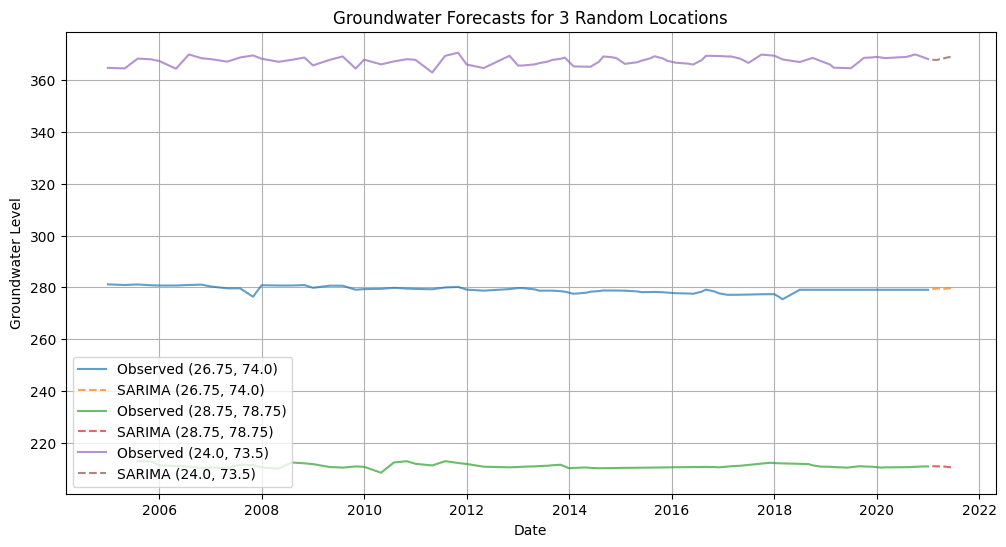

In [6]:
import matplotlib.pyplot as plt
import random

# Select 3 random locations
random_locations = random.sample(list(location_forecasts.keys()), 3)

# Create a single figure
plt.figure(figsize=(12, 6))

# Loop through selected locations and plot in the same figure
for (lat, lon) in random_locations:
    forecast_df = location_forecasts[(lat, lon)]
    group = location_groups.get_group((lat, lon))

    # Plot historical data (without markers)
    plt.plot(group['Date'], group['Groundwater_Level'], label=f'Observed ({lat}, {lon})', linestyle='-', alpha=0.7)

    # Plot Spline predictions if available
    if 'Spline_Prediction' in forecast_df:
        plt.plot(forecast_df['Date'], forecast_df['Spline_Prediction'], linestyle='--', label=f'Spline ({lat}, {lon})', alpha=0.7)

    # Plot SARIMA predictions if available
    if 'SARIMA_Prediction' in forecast_df:
        plt.plot(forecast_df['Date'], forecast_df['SARIMA_Prediction'], linestyle='--', label=f'SARIMA ({lat}, {lon})', alpha=0.7)

# Formatting
plt.xlabel('Date')
plt.ylabel('Groundwater Level')
plt.title('Groundwater Forecasts for 3 Random Locations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


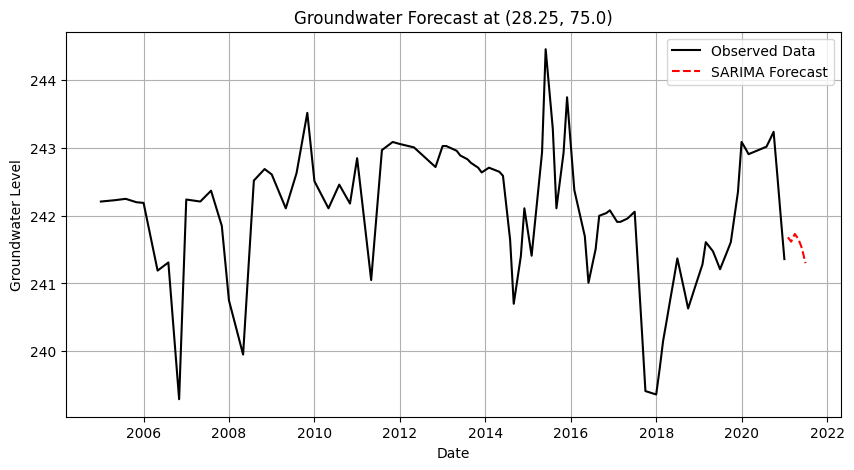

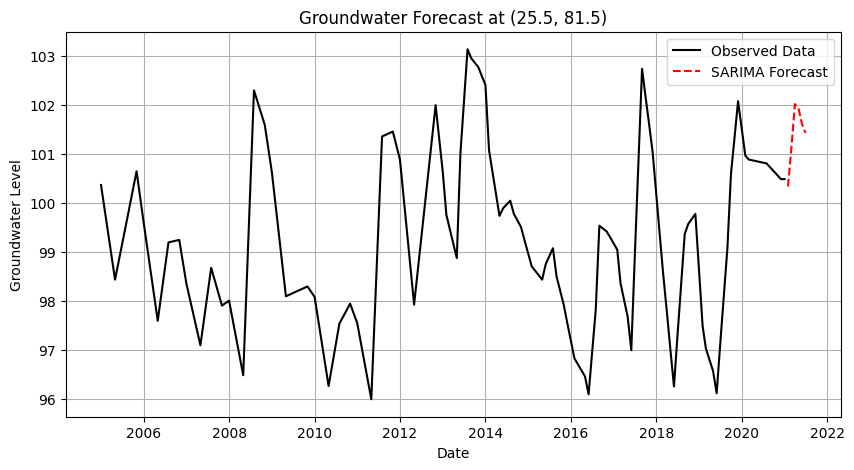

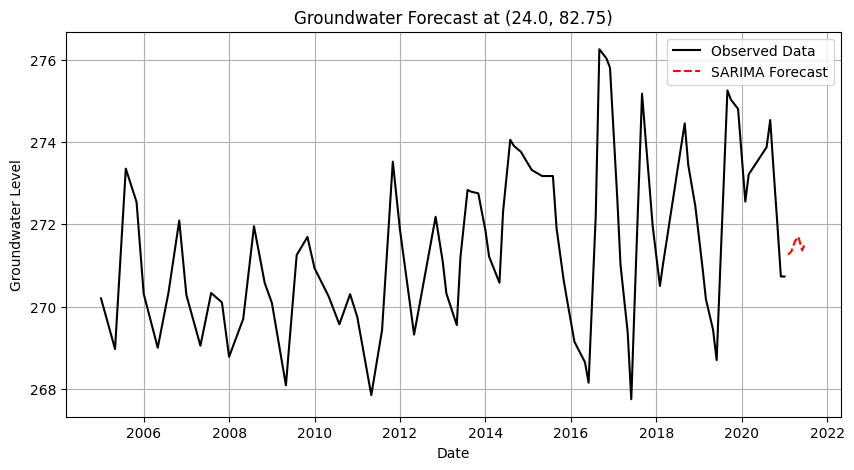

In [7]:
import matplotlib.pyplot as plt
import random

# Select 3 random locations
random_locations = random.sample(list(location_forecasts.keys()), 3)

# Loop through selected locations and generate separate plots
for (lat, lon) in random_locations:
    forecast_df = location_forecasts[(lat, lon)]
    group = location_groups.get_group((lat, lon))

    plt.figure(figsize=(10, 5))  # Create a new figure for each location

    # Plot historical data (without markers)
    plt.plot(group['Date'], group['Groundwater_Level'], label='Observed Data', linestyle='-', color='black')

    # Plot Spline predictions if available
    if 'Spline_Prediction' in forecast_df:
        plt.plot(forecast_df['Date'], forecast_df['Spline_Prediction'], linestyle='--', color='blue', label='Spline Forecast')

    # Plot SARIMA predictions if available
    if 'SARIMA_Prediction' in forecast_df:
        plt.plot(forecast_df['Date'], forecast_df['SARIMA_Prediction'], linestyle='--', color='red', label='SARIMA Forecast')

    # Formatting
    plt.xlabel('Date')
    plt.ylabel('Groundwater Level')
    plt.title(f'Groundwater Forecast at ({lat}, {lon})')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()
